In [29]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as sc

import ipywidgets as widgets
from IPython.display import display

In [30]:
sep = '\n' + '-' * 30 +'\n'
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Input Data

Time and Financing

In [31]:
df = {}
timeframe = 110

# Build dataframe 
#df['r = 0%'] = pd.DataFrame(index=np.arange(timeframe))
#df['r = 1%'] = pd.DataFrame(index=np.arange(timeframe))
#df['r = 2%'] = pd.DataFrame(index=np.arange(timeframe))
#df['r = 3%'] = pd.DataFrame(index=np.arange(timeframe))
df['r = 4%'] = pd.DataFrame(index=np.arange(timeframe))
#df['r = 5%'] = pd.DataFrame(index=np.arange(timeframe))
#df['r = 6%'] = pd.DataFrame(index=np.arange(timeframe))
df['r = 7%'] = pd.DataFrame(index=np.arange(timeframe))
#df['r = 8%'] = pd.DataFrame(index=np.arange(timeframe))
#df['r = 9%'] = pd.DataFrame(index=np.arange(timeframe))
#df['r = 10%'] = pd.DataFrame(index=np.arange(timeframe))
# Taux "Variable" #1
#df['r = V1'] = pd.DataFrame(index=np.arange(timeframe))

# Fill dataframe 
#df['r = 0%']['Taux d\'actualisation'] = 0.00;
#df['r = 1%']['Taux d\'actualisation'] = 0.01;
#df['r = 2%']['Taux d\'actualisation'] = 0.02;
#df['r = 3%']['Taux d\'actualisation'] = 0.03;
df['r = 4%']['Taux d\'actualisation'] = 0.04;
#df['r = 5%']['Taux d\'actualisation'] = 0.05;
#df['r = 6%']['Taux d\'actualisation'] = 0.06;
df['r = 7%']['Taux d\'actualisation'] = 0.07;
#df['r = 8%']['Taux d\'actualisation'] = 0.08;
#df['r = 9%']['Taux d\'actualisation'] = 0.09;
#df['r = 10%']['Taux d\'actualisation'] = 0.1;
# Taux "Variable" #1
#df['r = V1']['Taux d\'actualisation'] = 0.00;

# Years
for key in df:
    df[key]["Année"] = df[key].index - 20

first_key = list(df.keys())[0]

# Taux "Variable" #1
#df['r = V1']['Taux d\'actualisation'] = np.where(df['r = V1']['Année'] < 30,0.04,0.02)


Activated modules

In [32]:
b_construction = True
b_construction_profile = 'uniform' # [uniform], [gaus] or [user]
method_idc = 'ceu2008' # [ceu2008], [discount] or [direct]

b_production = True
b_production_omfix = True


Time Frame

In [33]:
if b_production:
    production_period = 30
    production_start = 0
    production_stop  = production_start + production_period - 1
    for key in df:
        df[key]['Phase Production'] = np.where((df[key]['Année']>=production_start) & (df[key]['Année']<=production_stop), True, False)

if b_construction:
    construction_period = 1
    construction_start = production_start - construction_period
    construction_stop  = production_start - 1
    for key in df:
        df[key]['Phase Construction'] = np.where((df[key]['Année']>=construction_start) & (df[key]['Année']<=construction_stop), True, False)


Project size

In [34]:
power_electric = 2e6
loadfactor = 0.30

Construction Costs [B €]

In [35]:
# Overnight Construction Cost : IRENA 2019 provides [850 - 1500 - 1875] as [q5 - med - q95]
cost_construction_occ = 1500 * power_electric * 1e-3
# Interest During Construction
cost_construction_idc = 0

Other costs

In [36]:
# Fix OM : ON SHORE = 40 €/kW - OFF SHORE = 75 €/kW
cost_fix_om = 40 * power_electric / 1e3


# Profile Cost and Energy

Energy production

In [37]:
if b_production:
    for key in df:
        df[key]['Facteur de Charge'] = np.where(df[key]['Phase Production']==True,loadfactor,0)
        df[key]['Energie'] = power_electric * df[key]['Facteur de Charge'] * 1e-6 * 365.25 * 24.
        df[key]['Energie A'] = df[key]['Energie'] / (1 + df[key]['Taux d\'actualisation'])**(df[key]['Année']+0.5)

Construction

In [38]:
cost_construction_idc = {}
cost_construction_tic = {}

for key in df:
    df[key]['Phase Construction'] = np.where((df[key]['Année']>=construction_start) & (df[key]['Année']<=construction_stop), True, False)
    df[key]['Coût Construction']   = 0
    df[key]['Coût Construction A'] = 0
    df[key]['Interets Intercalaires'] = 0
    df[key]['Coût Construction Total'] = 0
    df[key]['Coût Construction Total Cum'] = 0
    cost_construction_idc[key] = 0
    if b_construction:
    
        # ----------------------------------------
        # Profile of construction costs
        # ----------------------------------------
        # Profile Uniform
        if b_construction_profile == 'uniform':
            df[key]['Coût Construction']   = np.where(df[key]['Phase Construction']==True,cost_construction_occ/construction_period,0)
            df[key]['Coût Construction A'] = df[key]['Coût Construction'] / (1 + df[key]['Taux d\'actualisation'])**(df[key]['Année']+0.5)
    
        # Profile User (Here from D'Haeseleer table)
        if b_construction_profile == 'user':
            df[key].loc[15,'Coût Construction'] = 0.10 * cost_construction_occ
            df[key].loc[16,'Coût Construction'] = 0.25 * cost_construction_occ
            df[key].loc[17,'Coût Construction'] = 0.30 * cost_construction_occ
            df[key].loc[18,'Coût Construction'] = 0.25 * cost_construction_occ
            df[key].loc[19,'Coût Construction'] = 0.10 * cost_construction_occ
            df[key]['Coût Construction A'] = df[key]['Coût Construction'] / (1 + df[key]['Taux d\'actualisation'])**(df[key]['Année']+0.5)
            if df[key]['Coût Construction'].astype(bool).sum(axis=0)!= construction_period:
                print('ERROR... construction period is different from cash flow dimension!')
            if df[key]['Coût Construction'].sum() != cost_construction_occ:
                print('ERROR... construction overnight cost should be equal to the sum of cash flow!')
    
        # Profile normal
        if b_construction_profile == 'gaus':
            m = (construction_start+construction_stop)/2
            s = construction_period / 3;
            df[key]['Coût Construction']   = np.where(df[key]['Phase Construction']==True,sc.norm.pdf(df[key]['Année']+0.5,m,s),0)
            df[key]['Coût Construction']   = df[key]['Coût Construction'] / df[key]['Coût Construction'].sum() * cost_construction_occ
            df[key]['Coût Construction A'] = df[key]['Coût Construction'] / (1 + df[key]['Taux d\'actualisation'])**(df[key]['Année']+0.5)
    
        # ----------------------------------------
        # Interest During Construction calculation
        # ----------------------------------------
        # Formulae from European Commission showed in D'Haeseler - Ref is 30/06 of the year
        if method_idc == 'ceu2008':
            idc_fract = 0
            for t in df[key].index[df[key]['Phase Construction'] == True].tolist():
                idc_fract = idc_fract + df[key]['Coût Construction'][t]/cost_construction_occ * ((1+df[key]['Taux d\'actualisation'][t])**(-df[key]['Année'][t]-0.5) - 1)
            cost_construction_idc[key] = idc_fract * cost_construction_occ
                
        # Each steps of construction is used to calculate IDC (from D'Haeseleer table)
        if method_idc == 'direct':
            for t in df[key].index[df[key]['Phase Construction'] == True].tolist():
                df[key].loc[t,'Interets Intercalaires']  = df[key]['Taux d\'actualisation'][t-1] * df[key]['Coût Construction Total Cum'][t-1]
                df[key].loc[t,'Coût Construction Total'] = df[key]['Coût Construction'][t] + df[key]['Interets Intercalaires'][t]              
                df[key].loc[t,'Coût Construction Total Cum'] = df[key]['Coût Construction Total Cum'][t-1] + df[key]['Coût Construction Total'][t]
            # Add 6 month interest to FIT (Ref is 30/06 of the year) -> Slightly different from direct and discount approach.
            df[key].loc[t+1,'Interets Intercalaires'] = df[key]['Taux d\'actualisation'][t-1] * df[key]['Coût Construction Total Cum'][t-1] / 2.
            cost_construction_idc[key] = df[key]['Interets Intercalaires'].sum()
            idc_fract = cost_construction_idc[key] / cost_construction_occ
    
        # Discounting the construction cash-flow
        if method_idc == 'discount':
            cost_construction_idc[key] = df[key]['Coût Construction A'].sum() - df[key]['Coût Construction'].sum()
            idc_fract = cost_construction_idc[key]/cost_construction_occ
        # total construction cost    
        cost_construction_tic[key] = cost_construction_idc[key] + cost_construction_occ


Production

In [39]:
for key in df:
    if b_production:
    
        # OM Fix
        if b_production_omfix:
            df[key]['Coût OM Fixe'] = np.where(df[key]['Phase Production']==True,cost_fix_om,0)
            df[key]['Coût OM Fixe A'] = df[key]['Coût OM Fixe'] / (1 + df[key]['Taux d\'actualisation'])**(df[key]['Année']+0.5)


# Plotting

Energy

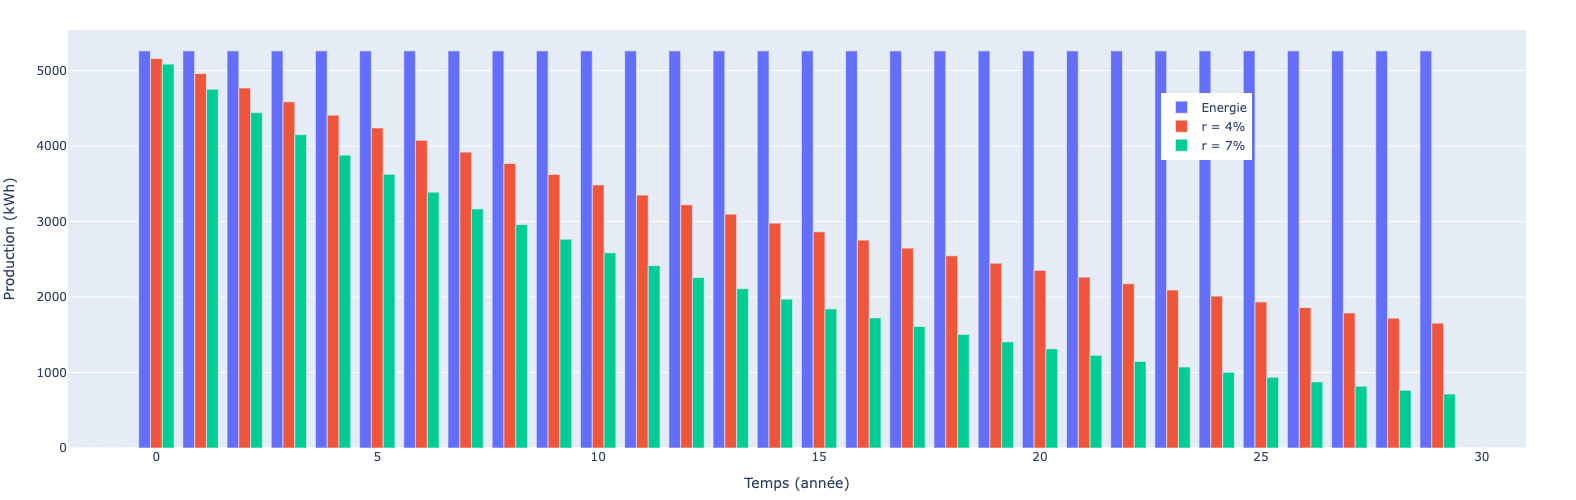

In [40]:
fig = go.Figure()

if b_production:
    fig.add_trace(go.Bar(
        name="Energie",
        x=df[first_key]["Année"], y=df[first_key]["Energie"]
    ))
    for key in df:
        fig.add_trace(go.Bar(name=key,x=df[key]["Année"], y=df[key]["Energie A"]))

fig.update_layout(title="",
                  xaxis_title="Temps (année)",
                  yaxis_title="Production (kWh)",
                  width=1000,
                  height=500,
                  margin=dict(l=50,r=50,b=30,t=30),
                  legend=dict(y=0.85,x=0.75)
                 )
fig.update_xaxes(range=[production_start-2,production_stop+2])

### Construction et intérêts intercalaires

In [41]:
fig = go.Figure()
if b_construction:
    if method_idc == 'direct':

        fig.add_trace(go.Bar(name="Construction",x=df[first_key]["Année"],y=df[first_key]["Coût Construction"]))
        for key in df:
            fig.add_trace(go.Bar(name='Intérêts Intercalaires - '+key,x=df[key]["Année"],y=df[key]["Interets Intercalaires"]))        
            #print(df[key]["Coût Construction"].sum()*1e-9,df[key]["Interets Intercalaires"].sum()*1e-9)
            
        fig.update_layout(#barmode='stack',
                          xaxis_title="Temps (année)",
                          yaxis_title="Dépense annuelle (€)",
                          width=1000,
                          height=500,
                          margin=dict(l=50,r=50,b=30,t=30),
                          legend=dict(y=0.95,x=0.70)
                          )
        fig.update_xaxes(range=[construction_start-2,construction_stop+2])
        fig.show()



Cash Flows

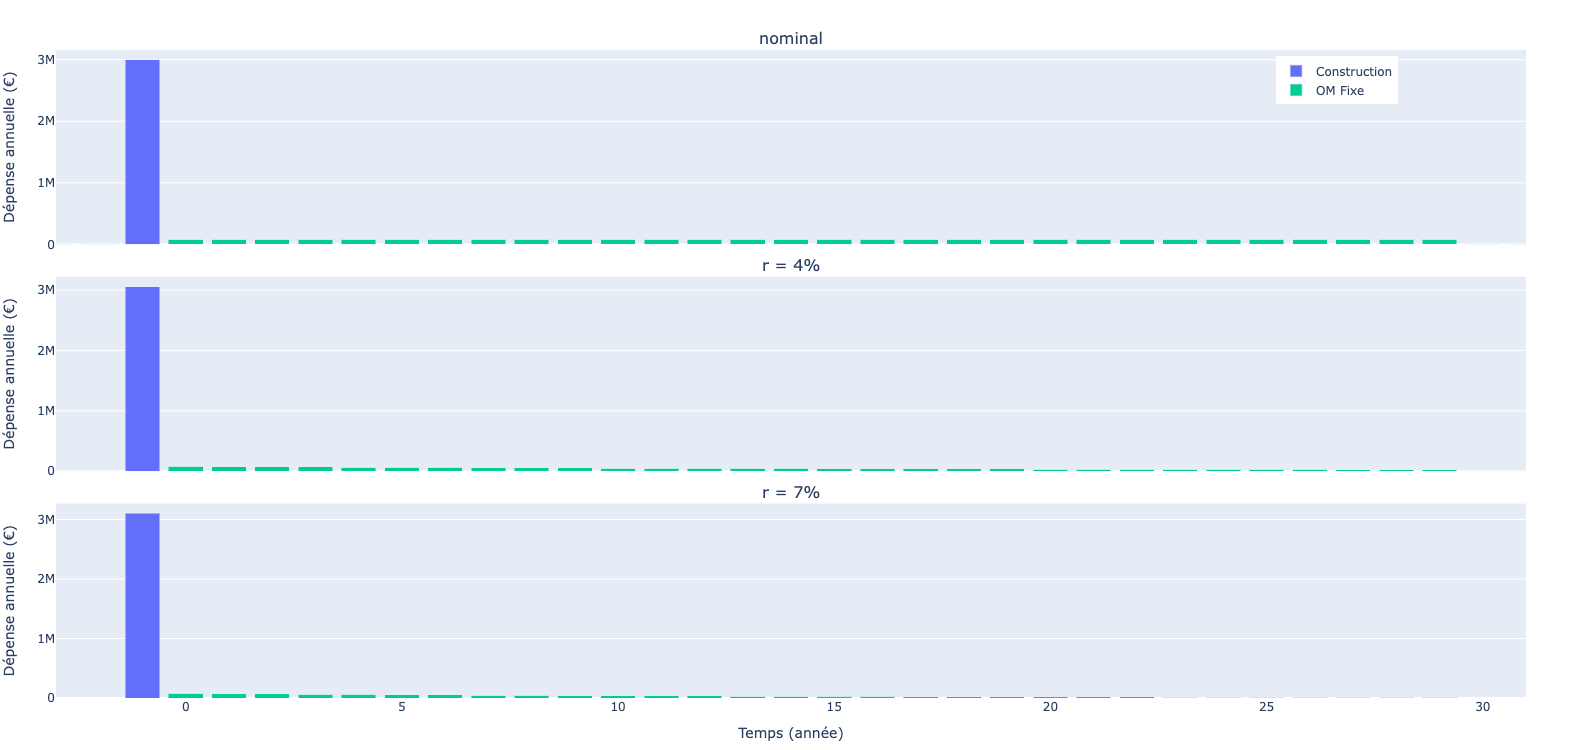

In [42]:
titles = list(df)
titles.insert(0, 'nominal')

fig = make_subplots(rows=len(df)+1, cols=1,shared_xaxes=True,vertical_spacing=0.05,subplot_titles=titles)

if b_production:
    if b_production_omfix:
        fig.add_trace(go.Bar(name="OM Fixe",x=df[first_key]["Année"],y=df[first_key]["Coût OM Fixe"],marker_color='#00CC96'),row=1,col=1)
        for index, key in enumerate(df):
            fig.add_trace(go.Bar(name="OM Fixe A.",x=df[key]["Année"],y=df[key]["Coût OM Fixe A"],marker_color='#00CC96',showlegend=False),row=2+index,col=1)
        
if b_construction:
    fig.add_trace(go.Bar(name="Construction",x=df[first_key]["Année"],y=df[first_key]["Coût Construction"],marker_color='#636EFA'),row=1,col=1)
    for index, key in enumerate(df):
        fig.add_trace(go.Bar(name="Construction",x=df[key]["Année"],y=df[key]["Coût Construction A"],marker_color='#636EFA',showlegend=False),row=2+index,col=1)        

fig.update_xaxes(title="Temps (année)",row=2+index)
fig.update_yaxes(title="Dépense annuelle (€)")
    
fig.update_layout(barmode='stack',
                  width=800,
                  height=250*(len(df)+1),
                  margin=dict(l=50,r=50,b=30,t=50),
                  legend=dict(y=0.99,x=0.83))

fig.update_xaxes(range=[construction_start-2,production_stop+2])
fig.show()


# LCOE Calculation and Share plot


 Phases et données :  

	 - Construction: 1500.0  €/kW
		 * Profile: uniform
		 * Méthode IDC: ceu2008
		 * OCC: 0.003  Md€
		 * IDC: 0.0  Md€
		 * TIC: 0.003  Md€
	 - Production
		 * OM Fix: 40.0  €/kW




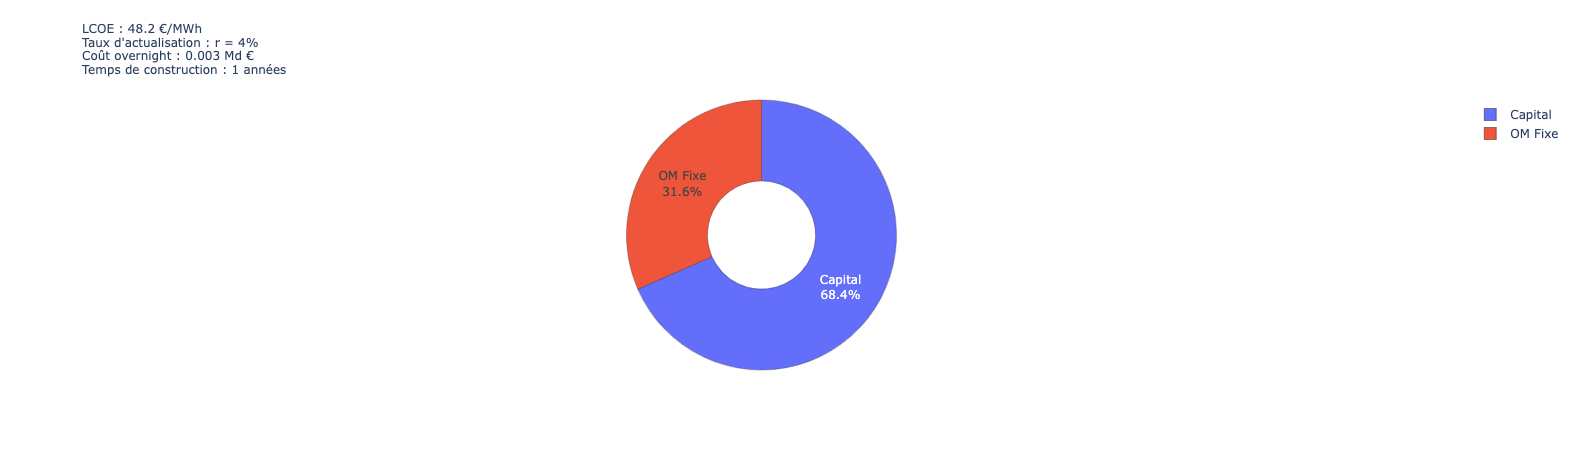




 Phases et données :  

	 - Construction: 1500.0  €/kW
		 * Profile: uniform
		 * Méthode IDC: ceu2008
		 * OCC: 0.003  Md€
		 * IDC: 0.0  Md€
		 * TIC: 0.003  Md€
	 - Production
		 * OM Fix: 40.0  €/kW




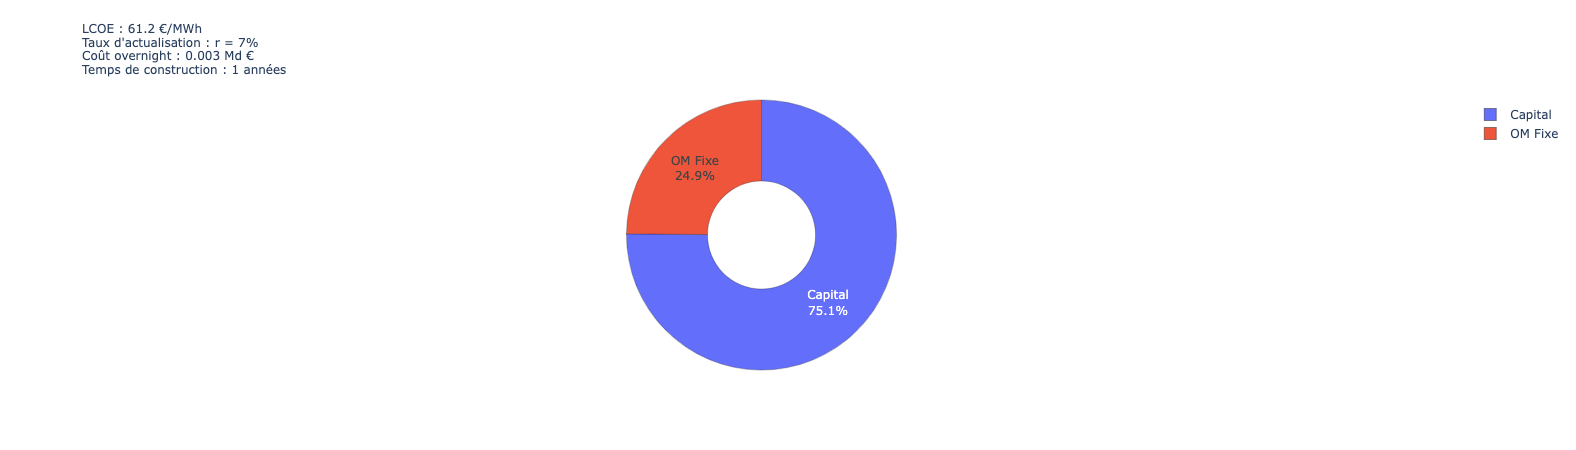

In [43]:
for key in df:
    cost_s = {}
    labels_lcoe = []
    values_lcoe = []
    colors_lcoe = []
    colors_lcoe_cap = []
    
    if b_construction:
        labels_lcoe.append('Capital')
        values_lcoe.append(df[key]["Coût Construction A"].sum())
        colors_lcoe.append('#636EFA')
    
    if b_production:
        if b_production_omfix:
            labels_lcoe.append('OM Fixe')
            values_lcoe.append(df[key]["Coût OM Fixe A"].sum())        
            colors_lcoe.append('#00CC96')
    
    if df[key]["Energie A"].sum() > 0:
        LCOE = sum(values_lcoe)/df[key]["Energie A"].sum()
    
    fig = go.Figure()
    
    fig.add_trace(go.Pie(labels=labels_lcoe, values=values_lcoe, name="LCOE", textinfo='label+percent',hole=.3,sort =False))
    
    fig.add_annotation(text='LCOE : '+str(round(LCOE, 1))+' €/MWh',xref="paper", yref="paper",x=0.0, y=1.30, showarrow=False)
    fig.add_annotation(text='Taux d\'actualisation : '+key,xref="paper", yref="paper",x=0.0, y=1.25, showarrow=False)
    fig.add_annotation(text='Coût overnight : '+str(cost_construction_occ/1e9)+' Md €',xref="paper", yref="paper",x=0.0, y=1.20, showarrow=False)
    fig.add_annotation(text='Temps de construction : '+str(construction_period)+' années',xref="paper", yref="paper",x=0.0, y=1.15, showarrow=False)

    fig.update_traces(hole=.4, hoverinfo="label+percent+name",insidetextorientation='horizontal')
    fig.update_traces(marker=dict(colors=colors_lcoe, line=dict(color='#000000', width=0.25)))
    fig.update_traces(marker=dict(colors=colors_lcoe_cap, line=dict(color='#000000', width=0.25)))

    print('\n','Phases et données : ','\n')
    if b_construction:
        print('\t - Construction:',cost_construction_occ/ power_electric * 1e3,' €/kW')
        print('\t\t * Profile:',b_construction_profile)
        print('\t\t * Méthode IDC:',method_idc)
        print('\t\t * OCC:',round(cost_construction_occ/1e9,3),' Md€')
        print('\t\t * IDC:',round(cost_construction_idc[key]/1e9,3),' Md€')
        print('\t\t * TIC:',round(cost_construction_tic[key]/1e9,3),' Md€')
    if b_production:
        print('\t - Production')
        print('\t\t * OM Fix:',cost_fix_om / power_electric * 1e3,' €/kW')
    print('\n')

    fig.show()
    print('\n')
